<center><img src='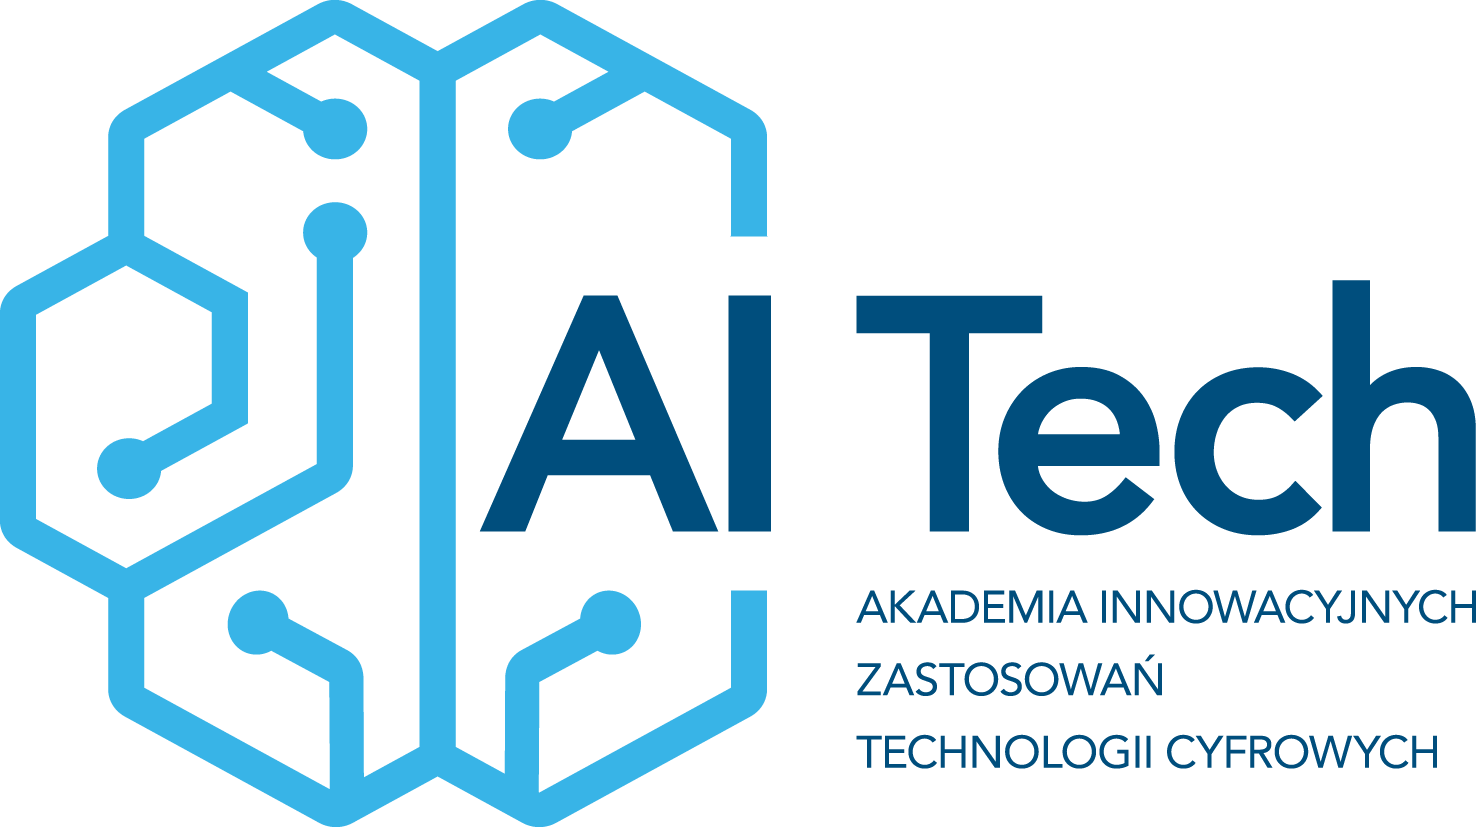
' height="60"></center>

AI TECH - Akademia Innowacyjnych Zastosowań Technologii Cyfrowych. Program Operacyjny Polska Cyfrowa na lata 2014-2020
<hr>

<center>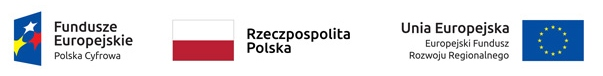</center>

<center>
Projekt współfinansowany ze środków Unii Europejskiej w ramach Europejskiego Funduszu Rozwoju Regionalnego 
Program Operacyjny Polska Cyfrowa na lata 2014-2020,
Oś Priorytetowa nr 3 "Cyfrowe kompetencje społeczeństwa" Działanie  nr 3.2 "Innowacyjne rozwiązania na rzecz aktywizacji cyfrowej" 
Tytuł projektu:  „Akademia Innowacyjnych Zastosowań Technologii Cyfrowych (AI Tech)”
    </center>

**Author: Tomasz Pawłowski**




# ML in big scale - LAB 9



## Advanced streaming techniques

* Word count on a stream
* windowing
* Flojet-Martin - estimating number of distinct elements
* Moments of a stream - how predictable is the stream




In [1]:
!apt-get install netcat-openbsd -y  > /dev/null

In [2]:
%%script bash --bg
# note: We are not using kafka because pyspark does not allow 
if [ ! -f sample_data/balladyna.txt ]; then
  wget -q https://wolnelektury.pl/media/book/txt/balladyna.txt -O sample_data/balladyna.txt
fi


while true; do
  while read line; do 
    echo -e -n "$line\n"
    sleep 1
  done < sample_data/balladyna.txt
done | nc -l -k 0.0.0.0 3000 >/dev/null


In [3]:
# Uncomment the following to stop the background process feeding topic testbook with data
#!killall nc
!ps -ax | grep "nc"

     34 ?        Sl     0:00 /usr/colab/bin/kernel_manager_proxy --listen_port=6000 --target_port=9000 --listen_host=172.28.0.12 --target_host=172.28.0.12 --tunnel_background_save_url=https://colab.research.google.com/tun/m/cc48301118ce562b961b3c22d803539adc1e0c19/m-s-1b2795jnrq8l1 --tunnel_background_save_delay=10s --tunnel_periodic_background_save_frequency=30m0s --enable_output_coalescing=true --output_coalescing_required=true
     63 ?        Z      0:06 [python3] <defunct>
   7212 ?        Ssl    0:01 /usr/bin/python3 -m ipykernel_launcher -f /root/.local/share/jupyter/runtime/kernel-8cb8248f-10db-4b09-ae76-040484e9f4cb.json
   7256 ?        Sl     0:00 node /datalab/web/pyright/pyright-langserver.js --stdio --cancellationReceive=file:2de808bf3a8cbf0980ed2267116eef9d170a95d784
   7284 ?        S      0:00 nc -l -k 0.0.0.0 3000
   7286 ?        S      0:00 /bin/bash -c ps -ax | grep "nc"
   7288 ?        S      0:00 grep nc


In [4]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [5]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.streaming import StreamingContext

spark = SparkSession.builder \
                    .master("local[*]") \
                    .appName("mlibs") \
                    .getOrCreate()

scc = StreamingContext(spark.sparkContext, 1)

### Example 1: Reading stream from a socket

In [6]:
from pyspark.sql.functions import concat, col, lit

lines = spark \
    .readStream \
    .format("socket") \
    .option("host", "localhost") \
    .option("port", 3000) \
    .load()

query = lines \
    .writeStream \
    .foreachBatch(lambda df, id: df.show()) \
    .start()

query.awaitTermination(5)
query.stop()

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/py4j/clientserver.py", line 617, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/usr/local/lib/python3.8/dist-packages/pyspark/sql/utils.py", line 272, in call
    raise e
  File "/usr/local/lib/python3.8/dist-packages/pyspark/sql/utils.py", line 269, in call
    self.func(DataFrame(jdf, self.session), batch_id)
  File "<ipython-input-6-2e15bb17b00d>", line 12, in <lambda>
    .foreachBatch(lambda df, id: df.show()) \
  File "/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py", line 606, in show
    print(self._jdf.showString(n, 20, vertical))
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1321, in __call__
    return_value = get_return_value(
  File "/usr/local/lib/python3.8/dist-packages/pyspark/sql/utils.py", line 190, in dec

### Example 2: Running Word Count

Split each line from the lines stream into words. Then generate a stream of pairs (word, number of occurrences in the stream). Write the result to console. Test what are the differences between output modes: "complete", "append", and "update".

Note: running a pyspark backend with hdfs is needed for this exercise. Use your spark cluster.

Use a window of 5 seconds with a 2 second watermark.

In [8]:
from pyspark.sql.functions import explode, split, length, lower, current_timestamp, window

words = lines.select(
   explode(
       split(lines.value, r"\s+")
   ).alias("word")
).filter(length("word") > 0).select(lower("word").alias("word")).withColumn("timestamp", current_timestamp())

query = words.writeStream \
      .foreachBatch(lambda df, id: df.show()) \
      .start()

query.awaitTermination(5)
query.stop()

windowedWordCounts = words.groupBy(
    window(words.timestamp, "5 seconds", "2 second"),
    words.word
).count()

def write_df(df, b):
  df.show()

query = windowedWordCounts.writeStream \
      .outputMode("update") \
      .foreachBatch(write_df) \
      .start()

query.awaitTermination(20)
query.stop()

+----+---------+
|word|timestamp|
+----+---------+
+----+---------+

+----------+--------------------+
|      word|           timestamp|
+----------+--------------------+
|       akt|2023-02-05 10:46:...|
|  pierwszy|2023-02-05 10:46:...|
|     scena|2023-02-05 10:46:...|
|         i|2023-02-05 10:46:...|
|         /|2023-02-05 10:46:...|
|       las|2023-02-05 10:46:...|
|    blisko|2023-02-05 10:46:...|
|   jeziora|2023-02-05 10:46:...|
|     gopła|2023-02-05 10:46:...|
|         —|2023-02-05 10:46:...|
|     chata|2023-02-05 10:46:...|
|pustelnika|2023-02-05 10:46:...|
| ustrojona|2023-02-05 10:46:...|
|  kwiatami|2023-02-05 10:46:...|
|         i|2023-02-05 10:46:...|
|bluszczem.|2023-02-05 10:46:...|
|         —|2023-02-05 10:46:...|
|    kirkor|2023-02-05 10:46:...|
|   wchodzi|2023-02-05 10:46:...|
|         w|2023-02-05 10:46:...|
+----------+--------------------+
only showing top 20 rows

+----+---------+
|word|timestamp|
+----+---------+
+----+---------+

+----+---------+
|wo

ERROR:py4j.clientserver:There was an exception while executing the Python Proxy on the Python Side.
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/py4j/clientserver.py", line 617, in _call_proxy
    return_value = getattr(self.pool[obj_id], method)(*params)
  File "/usr/local/lib/python3.8/dist-packages/pyspark/sql/utils.py", line 272, in call
    raise e
  File "/usr/local/lib/python3.8/dist-packages/pyspark/sql/utils.py", line 269, in call
    self.func(DataFrame(jdf, self.session), batch_id)
  File "<ipython-input-8-fe64c8f4eb11>", line 22, in write_df
    df.show()
  File "/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py", line 606, in show
    print(self._jdf.showString(n, 20, vertical))
  File "/usr/local/lib/python3.8/dist-packages/py4j/java_gateway.py", line 1321, in __call__
    return_value = get_return_value(
  File "/usr/local/lib/python3.8/dist-packages/pyspark/sql/utils.py", line 190, in deco
    return f(*a, **kw)
  File 

In [9]:
scc.stop()
spark.stop()

## Algorithms


### Flojet-Martin Algorithm

#### Exercise 1

Implement Flajolet-Martin Algorithm (estimating number of distinct elements in a stream) using following hashing functions:

$h_1(x)=x\quad(mod\quad128)$

$h_2(x)=3x+2\quad(mod\quad128)$

$h_3(x)=5x+1\quad(mod\quad128)$

$h_4(x)=7x+3\quad(mod\quad128)$

$h_5(x)=11x+5\quad(mod\quad128)$

$h_6(x)=11x+9\quad(mod\quad128)$

with calculating median of averages of ($h_1$, $h_6$), ($h_2$, $h_5$) and ($h_3$, $h_4$) and stream: $2, 2, 5, 3, 1, 1, 3, 7, 2$.

You can also use a variable number of hash funcitons using mmh3 library (see lab8 for details).

Calculate estimations and actual values after each element of the stream.

Note: there is no need of using spark - you can write your solution in pure python, but iterate over the generator only once

In [29]:
from statistics import median, mean

stream = (x for x in [2,2,5,3,1,1,3,7,2])
# put your code here, iterate over stream only once

hash_functions = [
    lambda x: x % 128,
    lambda x: (3*x+2) % 128,
    lambda x: (5*x+1) % 128,
    lambda x: (7*x+3) % 128,
    lambda x: (11*x+5) % 128,
    lambda x: (11*x+9) % 128
]

PHI = 0.77351

def estimate(r):
  return (2**r) / PHI

def largest_power(n, M = 7):
  res = 0
  if n == 0:
    return M
  while n % 2 == 0:
    res += 1
    n //= 2
  return res


def flajolet_martin(stream, hash_functions, mean_pairs):
    bitsets = [[0]*8 for _ in hash_functions]
    exact_values = set()
    trailing_zeros = []
    
    for value in stream:
      est = []
      exact_values.add(value)
      print(f'Exact values: {len(exact_values)}')
      for hash_, bitset in zip(hash_functions, bitsets):
        hashed_value = hash_(value)
        bitset[largest_power(hashed_value)] = 1
        k = bitset.index(0)
        est_ = estimate(k)
        est.append(est_)


      med = []
      for pair in mean_pairs:
        med.append(mean([est[pair[0]-1], est[pair[1]-1]]))
      print(f'Estimate: {"%.2f" % median(med)}')


flajolet_martin(stream, hash_functions, [(1,6), (2,5), (3,4)])

Exact values: 1
Estimate: 1.94
Exact values: 1
Estimate: 1.94
Exact values: 2
Estimate: 3.88
Exact values: 3
Estimate: 5.17
Exact values: 4
Estimate: 6.46
Exact values: 4
Estimate: 6.46
Exact values: 4
Estimate: 6.46
Exact values: 5
Estimate: 7.76
Exact values: 5
Estimate: 7.76


### Alon-Matias-Szegedy algorithm




#### Exercise 2

Calculate the second moment of the stream: `a,b,c,b,d,a,c,d,a,b,d,c,a,a,b`

In [31]:
stream = "a,b,c,b,d,a,c,d,a,b,d,c,a,a,b".split(',')
# put your code here (if needed - can be also solved on the blackboard)

def secondMoment(stream_):
    mydict = dict()
    for el in stream_:
        if el not in mydict:
            mydict[el] = 1
        else:
            mydict[el] += 1
    return (sum([pow(value, 2) for key, value in mydict.items()]))

print(secondMoment(stream))

59


#### Exercise 3

Calculate the approximation of the second moment using AMS algorithm. Use the stream above and constants $N=15$, and random positions 2, 7 and 12 (starting from 0).

Iterate over the stream only once!

In [51]:
stream = (x for x in "a,b,c,b,d,a,c,d,a,b,d,c,a,a,b".split(','))
sample_idx = [2, 7, 12]
constant = 15
# put your code here

def AMS_second_moment(N, stream, random_positions):
  sampled_elements = []
  count = []
  for i, el in enumerate(stream):
    if i in random_positions:
      sampled_elements.append(el)
      count.append(0)
    for j, smpl_el in enumerate(sampled_elements):
      if el == smpl_el:
        count[j] += 1
  return sum(2*c - 1 for c in count) * N // len(count)

print(AMS_second_moment(constant, stream, sample_idx))

55


#### Exercise 4 (Homework)

Imlement Alon-Matias-Szegedy algorithm (not necessary using spark). Take number of random values used for approximation as a parameter. Use Reservoir sampling for selecting random positions of the string. Print the approximation after processing each element after Nth.



In [49]:
import random

def ams(N, stream):
  # put your code here, but do not use the stream variable
  sample = []
  count = []

  for i, element in enumerate(stream):
    # put your code here, but do not use the stream variable
    if i < N:
      sample.append(element)
      count.append(0)
    else:
      r = random.randint(0, i)
      if r < N:
        sample[r] = element
        count[r] = 0

    for sample_i, sample_element in enumerate(sample):
      if element == sample_element:
        count[sample_i] += 1

    appr = sum(2*c - 1 for c in count) * i // len(count)
    print(f"iteration {i}: {appr}")


# how the function should work:
stream = (x for x in "a,b,c,b,d,a,c,d,a,b,d,c,a,a,b".split(','))
ams(3, stream)
stream_ = "a,b,c,b,d,a,c,d,a,b,d,c,a,a,b".split(',')
print(f'True second movement: {secondMoment(stream_)}')

iteration 0: 0
iteration 1: 1
iteration 2: 2
iteration 3: 5
iteration 4: 6
iteration 5: 8
iteration 6: 14
iteration 7: 16
iteration 8: 18
iteration 9: 33
iteration 10: 23
iteration 11: 33
iteration 12: 36
iteration 13: 39
iteration 14: 51
True second movement: 59


<center>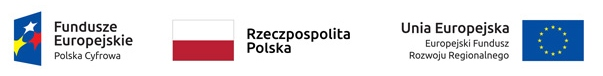</center>